In [1]:
import os
import sys
from pathlib import Path
import logging

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc

ROOT = '../'
sys.path.append(ROOT)
import came
from came import pipeline, pp, pl


Using backend: pytorch


In [2]:
def rotate_xticklabels(ax, angle=45, **kwargs):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=angle,
                       **kwargs)

In [3]:
def grid_bars_display_probas(
        df,
        labels,
        classes=None,
        figsize=(6, 5),
        sharey=True,
        **kwargs
):
    """ violin plots of the distributions """
    if classes is None:
        classes = sorted(set(labels))
    classes = [
        c for c in df.columns if c in classes] + [
        c for c in classes if c not in df.columns]
    labels = np.asarray(labels)
        
    fig, axs = plt.subplots(
        len(classes), 2, figsize=figsize,
        sharex=True, sharey=sharey,
        gridspec_kw={'hspace': 0.0, 'wspace': 0.}
    )
    for i, cl in enumerate(classes):
        df_sub = df[labels == cl]
#         y_mid = 0.4  # (df_sub.max() + df_sub.min()) / 2
        sns.barplot(data=df_sub, ax=axs[i, 1], **kwargs)
    
        ymin, ymax = 0.25, 1.05
        axs[i, 1].set_ylim(ymin, ymax)
        axs[i, 1].set_yticks([])
        y_mid = (ymax + ymin) / 2 - 0.2
        axs[i, 0].text(df.shape[1] - 1, y_mid, cl, ha='right')
        axs[i, 0].set_axis_off()
    rotate_xticklabels(axs[-1, 1], ha='right')
    return fig

# fig = grid_bars_display_probas(
#     df_probas, y_true, classes=None, 
#     figsize=(6, 6))

def grid_display_probas(
        df,
        labels,
        classes=None,
        figsize=(6, 5),
        sharey=True,
):
    """ violin plots of the distributions """
    if classes is None:
        classes = sorted(set(labels))
    classes = [
        c for c in df.columns if c in classes] + [
        c for c in classes if c not in df.columns]
    labels = np.asarray(labels)
    fig, axs = plt.subplots(
        len(classes), 2, figsize=figsize,
        sharex=True, sharey=sharey,
        gridspec_kw={'hspace': 0.0, 'wspace': 0.}
    )
    for i, cl in enumerate(classes):
        df_sub = df[labels == cl]
        y_mid = 0.4  # (df_sub.max() + df_sub.min()) / 2
        sns.violinplot(data=df_sub, ax=axs[i, 1], 
                       scale='width',
                       linewidth=.01, vmin=0)
#         sns.barplot(data=df, ax=axs[i, 1])
        axs[i, 1].set_ylim(-0.1, 1.1)
        axs[i, 0].text(df.shape[1] - 1, y_mid, cl, ha='right')
        axs[i, 0].set_axis_off()
    rotate_xticklabels(axs[-1, 1], ha='right')
    return fig


def grid_bars_display_probas_transposed(
        df,
        labels,
        classes=None,
        figsize=(5, 6),
        sharey=True,
        **kwargs
):
    """ bar plots of the distributions """
    if classes is None:
        classes = sorted(set(labels))
    classes = [
        c for c in df.columns if c in classes] + [
        c for c in classes if c not in df.columns]
    labels = np.asarray(labels)
    n_cl = len(classes)
    fig, axs = plt.subplots(
        2, len(classes), figsize=figsize,
        sharex=True, sharey=sharey,
        gridspec_kw={'hspace': 0.0, 'wspace': 0.}
    )
    for i, cl in enumerate(classes):
        df_sub = df[labels == cl]
        sns.barplot(data=df_sub, ax=axs[0, i], orient='h', **kwargs)
    
        xmin, xmax = 0.25, 1.05
        axs[0, i].set_xlim(xmin, xmax)
        axs[0, i].set_xticks([])
        x_mid = (xmax + xmin) / 2 - 0.2
        axs[1, i].text(0.6, -0.25, cl, 
                       ha='right', va='top', rotation=30)
        axs[1, i].set_axis_off()
    # rotate_xticklabels(axs[-1, 1], ha='right')
    return fig


In [4]:
dirname0 = Path(f"{ROOT}/_case_res")


In [8]:
dirname = dirname0 / "uk-('Lake_2018', 'Tasic18')(06-23 14.37.55)"
dirname = dirname0 / "uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)"
# dirname = dirname0 / "uk-('Lake_2018', 'Tosches_turtle')(06-28 01.13.23)" # 结果哦太差了!
dirname = dirname0 / "uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)"
# dirname = dirname0 / "uk-('Lake_2018', 'Tosches_turtle')(06-23 16.25.15)"

prob_func = 'sigmoid'
plt.rcParams.update({'font.family':'Arial'})

for sub in os.listdir(dirname):
    resdir = dirname / sub
    figdir = resdir / 'figs'
    df_logits2 = pd.read_csv(resdir / 'df_logits2.csv', index_col=0)
    
    predictor = came.Predictor.load(resdir / 'predictor.json')

    obs = pd.read_csv(resdir / 'obs.csv', index_col=0)

    dsn2 = obs['dataset'].iloc[-1]
    obs2 = obs[obs['dataset'] == dsn2]

#     y_true = obs2['celltype'].values
#     ref_classes = df_logits2.columns
    
    name_map = {
        'oligodendrocyte precursor cell': 'OPC',
        'vascular and leptomeningeal cell': 'VLMC',
        'smooth muscle cell': 'SMC'
    }
    reg_name = lambda x: name_map.get(x, x.capitalize())

    obs2['celltype'] = obs2['celltype'].apply(reg_name)

    y_true = obs2['celltype'].values
    ref_classes = [reg_name(c) for c in df_logits2.columns]

    print(ref_classes)
    print(pd.unique(y_true))
    
    df_probas = pd.DataFrame(
        data=came.as_probabilities(df_logits2, mode=prob_func),
        # data=predictor.predict_pvalues(df_logits2.values),
        columns=ref_classes
    )
    # bar-grid-plot
    fig = grid_bars_display_probas_transposed(
    df_probas, y_true, classes=None, 
    figsize=(6, 6))

    fig_types = ['pdf', 'svg']
    for ftype in fig_types:
        pl._save_with_adjust(fig, figdir / f"barGridTransposed-{prob_func}.{ftype}")

    n_cols = len(set(y_true))
    fig = grid_bars_display_probas(
        df_probas, y_true, classes=None, 
        figsize=(6, 6))
    
    for ftype in fig_types:
        pl._save_with_adjust(fig, figdir / f"barGrid-{prob_func}.{ftype}")
        

    # heatmap
    obs2['predicted'] = obs2['predicted'].apply(reg_name)
    gs = pl.wrapper_heatmap_scores(
            df_probas, obs2, ignore_index=True,
            cmap_heat='magma_r' if prob_func == 'softmax' else 'RdBu_r'
        )
    fig_types = ['pdf', 'svg']
    for ftype in fig_types:
        pl._save_with_adjust(gs.figure, figdir / f"new-heatMap-{prob_func}.{ftype}")


<ipython-input-8-69f6ddda0872>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['celltype'] = obs2['celltype'].apply(reg_name)


['Astrocyte', 'Inhibitory neuron', 'Excitatory neuron', 'Microglial cell', 'Oligodendrocyte', 'Cerebellar granule cell', 'OPC', 'Endothelial cell', 'Purkinje cell', 'Brain pericyte']
['Excitatory neuron' 'Inhibitory neuron' 'Astrocyte' 'Brain pericyte'
 'Microglial cell' 'Neural progenitor cell' 'OPC' 'Oligodendrocyte'
 'Leukocyte']
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\barGridTransposed-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\barGridTransposed-sigmoid.svg
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\barGrid-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\barGrid-sigmoid.svg


<ipython-input-8-69f6ddda0872>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['predicted'] = obs2['predicted'].apply(reg_name)


figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\new-heatMap-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-\figs\new-heatMap-sigmoid.svg
['Astrocyte', 'Microglial cell', 'Oligodendrocyte', 'Cerebellar granule cell', 'OPC', 'Endothelial cell', 'Purkinje cell', 'Brain pericyte']
['Excitatory neuron' 'Inhibitory neuron' 'Astrocyte' 'Brain pericyte'
 'Microglial cell' 'Neural progenitor cell' 'OPC' 'Oligodendrocyte'
 'Leukocyte']


<ipython-input-8-69f6ddda0872>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['celltype'] = obs2['celltype'].apply(reg_name)


figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\barGridTransposed-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\barGridTransposed-sigmoid.svg
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\barGrid-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\barGrid-sigmoid.svg


<ipython-input-8-69f6ddda0872>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['predicted'] = obs2['predicted'].apply(reg_name)


figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\new-heatMap-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)\rm-['inhibitory neuron', 'excitatory neuron']\figs\new-heatMap-sigmoid.svg


In [2]:
dirname = dirname0 / "uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)"
# dirname = dirname0 / "uk-('Lake_2018', 'Tosches_turtle')(06-24 10.31.44)"
# dirname = dirname0 / "uk-('Lake_2018', 'Tosches_turtle')(06-28 01.13.23)"

resdir = dirname / 'rm-'
figdir = resdir / 'figs'
os.listdir(dirname)


['rm-', "rm-['inhibitory neuron', 'excitatory neuron']"]

In [20]:
df_logits2 = pd.read_csv(resdir / 'df_logits2.csv', index_col=0)
    
predictor = came.Predictor.load(resdir / 'predictor.json')
# predictor.save(resdir / 'predictor-0.json') #backup

obs = pd.read_csv(resdir / 'obs.csv', index_col=0)

dsn2 = obs['dataset'].iloc[-1]
obs2 = obs[obs['dataset'] == dsn2]

y_true = obs2['celltype'].values
ref_classes = df_logits2.columns

print(ref_classes)
print(pd.unique(y_true))

Index(['astrocyte', 'inhibitory neuron', 'excitatory neuron',
       'microglial cell', 'oligodendrocyte', 'cerebellar granule cell',
       'oligodendrocyte precursor cell', 'endothelial cell', 'Purkinje cell',
       'brain pericyte'],
      dtype='object')
['inhibitory neuron' 'excitatory neuron' 'astrocyte'
 'vascular and leptomeningeal cell' 'oligodendrocyte' 'endothelial cell'
 'macrophage' 'smooth muscle cell' 'brain pericyte']


In [21]:
name_map = {
    'oligodendrocyte precursor cell': 'OPC',
    'vascular and leptomeningeal cell': 'VLMC',
    'smooth muscle cell': 'SMC'
}
reg_name = lambda x: name_map.get(x, x.capitalize())

obs2['celltype'] = obs2['celltype'].apply(reg_name)

y_true = obs2['celltype'].values
ref_classes = [reg_name(c) for c in df_logits2.columns]

print(ref_classes)
print(pd.unique(y_true))

['Astrocyte', 'Inhibitory neuron', 'Excitatory neuron', 'Microglial cell', 'Oligodendrocyte', 'Cerebellar granule cell', 'OPC', 'Endothelial cell', 'Purkinje cell', 'Brain pericyte']
['Inhibitory neuron' 'Excitatory neuron' 'Astrocyte' 'VLMC'
 'Oligodendrocyte' 'Endothelial cell' 'Macrophage' 'SMC' 'Brain pericyte']


<ipython-input-21-c8a7f146c01a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['celltype'] = obs2['celltype'].apply(reg_name)


In [22]:

prob_func = 'sigmoid'
df_probas = pd.DataFrame(
    data=came.as_probabilities(df_logits2, mode=prob_func),
    # data=predictor.predict_pvalues(df_logits2.values),
    columns=ref_classes
)


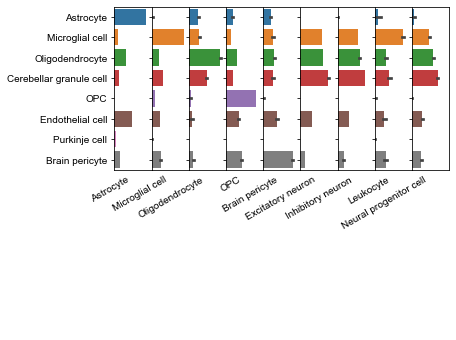

In [10]:
def grid_bars_display_probas_transposed(
        df,
        labels,
        classes=None,
        figsize=(5, 6),
        sharey=True,
        **kwargs
):
    """ bar plots of the distributions """
    if classes is None:
        classes = sorted(set(labels))
    classes = [
        c for c in df.columns if c in classes] + [
        c for c in classes if c not in df.columns]
    labels = np.asarray(labels)
    n_cl = len(classes)
    fig, axs = plt.subplots(
        2, len(classes), figsize=figsize,
        sharex=True, sharey=sharey,
        gridspec_kw={'hspace': 0.0, 'wspace': 0.}
    )
    for i, cl in enumerate(classes):
        df_sub = df[labels == cl]
#         y_mid = 0.4  # (df_sub.max() + df_sub.min()) / 2
        sns.barplot(data=df_sub, ax=axs[0, i], orient='h', **kwargs)
    
        xmin, xmax = 0.25, 1.05
        axs[0, i].set_xlim(xmin, xmax)
        axs[0, i].set_xticks([])
        x_mid = (xmax + xmin) / 2 - 0.2
        axs[1, i].text(0.6, -0.25, cl, ha='right', va='top', rotation=30)
        axs[1, i].set_axis_off()
    # rotate_xticklabels(axs[-1, 1], ha='right')
    return fig


fig = grid_bars_display_probas_transposed(
    df_probas, y_true, classes=None, 
    figsize=(6, 6))

In [25]:
fig_types = ['pdf', 'svg']
for ftype in fig_types:
    pl._save_with_adjust(fig, figdir / f"barGrid-{prob_func}.{ftype}")

figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)\rm-\figs\barGrid-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)\rm-\figs\barGrid-sigmoid.svg


In [28]:
# obs2['celltype'] = obs2['celltype'].apply(reg_name)
obs2['predicted'] = obs2['predicted'].apply(reg_name)

gs = pl.wrapper_heatmap_scores(
        df_probas, obs2, ignore_index=True,
        cmap_heat='magma_r' if prob_func == 'softmax' else 'RdBu_r'
    )
fig_types = ['pdf', 'svg']
for ftype in fig_types:
    pl._save_with_adjust(gs.figure, figdir / f"new-heatMap-{prob_func}.{ftype}")


<ipython-input-28-91fdfc66c289>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs2['predicted'] = obs2['predicted'].apply(reg_name)


figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)\rm-\figs\new-heatMap-sigmoid.pdf
figure has been saved into:
	..\_case_res\uk-('Lake_2018', 'Tasic18')(06-24 09.57.28)\rm-\figs\new-heatMap-sigmoid.svg


In [ ]:
# Violin-plot
fig = grid_display_probas(
    df_probas, y_true, figsize=(6, 6))
